In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

In [2]:
torch.manual_seed(42)
np.random.seed(42)
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS = 1  # Grayscale images
LATENT_DIM = 100
NUM_EPOCHS = 100
LEARNING_RATE = 0.0002
BETA1 = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
class FaceSketchDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = [f for f in os.listdir(root_dir) if f.endswith(('.jpg', '.png'))]
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        
        if self.transform:
            image = self.transform(image)
        
        return image


In [4]:
def load_data(data_path):
    transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    dataset = FaceSketchDataset(data_path, transform=transform)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    return dataloader

# Load dataset
data_path = "/kaggle/input/cuhk-face-sketch-database-cufs/cropped_sketch"  
dataloader = load_data(data_path)


# DCGAN

In [5]:
# Generator
class DCGANGenerator(nn.Module):
    def __init__(self):
        super(DCGANGenerator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(LATENT_DIM, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(64, CHANNELS, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)


In [7]:
# Discriminator
class DCGANDiscriminator(nn.Module):
    def __init__(self):
        super(DCGANDiscriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(CHANNELS, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.main(x).view(-1, 1).squeeze(1)        


# WesternGAN

In [8]:
# Generator
class WesternGANGenerator(nn.Module):
    def __init__(self):
        super(WesternGANGenerator, self).__init__()
        self.main = nn.Sequential(
            # Initial block
            nn.ConvTranspose2d(LATENT_DIM, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            # Upsampling blocks with residual connections
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            # Style enhancement blocks
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            # Final output
            nn.ConvTranspose2d(64, CHANNELS, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        
        # Style modulation layers
        self.style_mod = nn.Sequential(
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.InstanceNorm2d(64),
            nn.ReLU(True)
        )

    def forward(self, x):
        features = self.main[:-2](x)  # Extract features before final layer
        style = self.style_mod(features)  # Apply style modulation
        features = features + style  # Residual connection
        return self.main[-2:](features)  # Final output layers

In [9]:
#Discriminator
class WesternGANDiscriminator(nn.Module):
    def __init__(self):
        super(WesternGANDiscriminator, self).__init__()
        self.main = nn.Sequential(
            # Initial feature extraction
            nn.Conv2d(CHANNELS, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Style-aware discrimination
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Final discrimination
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1, 1).squeeze(1)


# VAE 

In [10]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(CHANNELS, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(256 * 4 * 4, LATENT_DIM)
        self.fc_var = nn.Linear(256 * 4 * 4, LATENT_DIM)

        self.decoder_input = nn.Linear(LATENT_DIM, 256 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, CHANNELS, 4, 2, 1),
            nn.Tanh()
        )
        
    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(x.size(0), 256, 4, 4)
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

# Training

In [11]:
def train_dcgan(dataloader, num_epochs):
    netG = DCGANGenerator().to(device)
    netD = DCGANDiscriminator().to(device)
    
    criterion = nn.BCELoss()
    optimizerD = optim.Adam(netD.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))
    
    G_losses = []
    D_losses = []
    
    for epoch in range(num_epochs):
        for i, data in enumerate(dataloader):
            # Train Discriminator
            netD.zero_grad()
            real = data.to(device)
            batch_size = real.size(0)
            label_real = torch.ones(batch_size).to(device)
            label_fake = torch.zeros(batch_size).to(device)
            
            output_real = netD(real)
            D_loss_real = criterion(output_real, label_real)
            
            noise = torch.randn(batch_size, LATENT_DIM, 1, 1).to(device)
            fake = netG(noise)
            output_fake = netD(fake.detach())
            D_loss_fake = criterion(output_fake, label_fake)
            
            D_loss = D_loss_real + D_loss_fake
            D_loss.backward()
            optimizerD.step()
            
            # Train Generator
            netG.zero_grad()
            output_fake = netD(fake)
            G_loss = criterion(output_fake, label_real)
            G_loss.backward()
            optimizerG.step()
            
            if i % 100 == 0:
                print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] Loss_D: {D_loss.item():.4f} Loss_G: {G_loss.item():.4f}')
            
            G_losses.append(G_loss.item())
            D_losses.append(D_loss.item())
    
    return netG, netD, G_losses, D_losses


In [17]:
def train_westerngan(dataloader, num_epochs):
    netG = WesternGANGenerator().to(device)
    netD = WesternGANDiscriminator().to(device)
    
    criterion = nn.BCELoss()
    optimizerD = optim.Adam(netD.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))
    
    G_losses = []
    D_losses = []
    
    for epoch in range(num_epochs):
        for i, data in enumerate(dataloader):
            # Train Discriminator
            netD.zero_grad()
            real = data.to(device)
            batch_size = real.size(0)
            label_real = torch.ones(batch_size).to(device)
            label_fake = torch.zeros(batch_size).to(device)
            
            output_real = netD(real)
            D_loss_real = criterion(output_real, label_real)
            
            noise = torch.randn(batch_size, LATENT_DIM, 1, 1).to(device)
            fake = netG(noise)
            output_fake = netD(fake.detach())
            D_loss_fake = criterion(output_fake, label_fake)
            
            # Calculate style loss separately for discriminator
            style_loss_D = torch.mean(torch.abs(fake.detach() - real))
            
            D_loss = D_loss_real + D_loss_fake + 0.1 * style_loss_D
            D_loss.backward()
            optimizerD.step()
            
            # Train Generator
            netG.zero_grad()
            output_fake = netD(fake)
            
            # Calculate style loss separately for generator
            style_loss_G = torch.mean(torch.abs(fake - real))
            
            G_loss = criterion(output_fake, label_real) + 0.1 * style_loss_G
            G_loss.backward()
            optimizerG.step()
            
            if i % 100 == 0:
                print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] '
                      f'Loss_D: {D_loss.item():.4f} Loss_G: {G_loss.item():.4f}')
            
            G_losses.append(G_loss.item())
            D_losses.append(D_loss.item())
    
    return netG, netD, G_losses, D_losses

In [14]:
def train_vae(dataloader, num_epochs):
    vae = VAE().to(device)
    optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE)
    
    recon_losses = []
    kl_losses = []
    total_losses = []
    
    for epoch in range(num_epochs):
        for i, data in enumerate(dataloader):
            data = data.to(device)
            optimizer.zero_grad()
            
            recon_batch, mu, log_var = vae(data)
            
            # Reconstruction loss
            recon_loss = nn.MSELoss()(recon_batch, data)
            
            # KL divergence loss
            kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            kl_loss = kl_loss / (BATCH_SIZE * IMAGE_SIZE * IMAGE_SIZE)  # Normalize
            
            # Total loss
            loss = recon_loss + kl_loss
            loss.backward()
            optimizer.step()
            
            if i % 100 == 0:
                print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] '
                      f'Recon Loss: {recon_loss.item():.4f} '
                      f'KL Loss: {kl_loss.item():.4f} '
                      f'Total Loss: {loss.item():.4f}')
            
            recon_losses.append(recon_loss.item())
            kl_losses.append(kl_loss.item())
            total_losses.append(loss.item())
    
    return vae, recon_losses, kl_losses, total_losses

In [15]:
def plot_losses(G_losses, D_losses, title):
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.plot(G_losses, label="Generator")
    plt.plot(D_losses, label="Discriminator")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_vae_losses(recon_losses, kl_losses, total_losses):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.title("VAE Reconstruction and KL Losses")
    plt.plot(recon_losses, label="Reconstruction")
    plt.plot(kl_losses, label="KL Divergence")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.title("VAE Total Loss")
    plt.plot(total_losses, label="Total Loss", color='green')
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def generate_and_save_samples(model_type, model, epoch, num_samples=16):
    with torch.no_grad():
        if model_type in ['dcgan', 'westerngan']:
            noise = torch.randn(num_samples, LATENT_DIM, 1, 1).to(device)
            generated = model(noise).cpu()
        else:  # VAE
            noise = torch.randn(num_samples, LATENT_DIM).to(device)
            generated = model.decode(noise).cpu()
        
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        plt.title(f"{model_type.upper()} Generated Samples - Epoch {epoch}")
        plt.imshow(np.transpose(vutils.make_grid(
            generated, padding=2, normalize=True), (1, 2, 0)), cmap='gray')
        plt.savefig(f'samples_{model_type}_epoch_{epoch}.png')
        plt.close()

def compare_models_samples(dcgan_gen, westerngan_gen, vae_model, num_samples=8):
    plt.figure(figsize=(15, 5))
    # DCGAN samples
    plt.subplot(1, 3, 1)
    with torch.no_grad():
        noise = torch.randn(num_samples, LATENT_DIM, 1, 1).to(device)
        dcgan_samples = dcgan_gen(noise).cpu()
    plt.axis("off")
    plt.title("DCGAN Samples")
    plt.imshow(np.transpose(vutils.make_grid(
        dcgan_samples, padding=2, normalize=True), (1, 2, 0)), cmap='gray')
    
    # WesternGAN samples
    plt.subplot(1, 3, 2)
    with torch.no_grad():
        noise = torch.randn(num_samples, LATENT_DIM, 1, 1).to(device)
        western_samples = westerngan_gen(noise).cpu()
    plt.axis("off")
    plt.title("WesternGAN Samples")
    plt.imshow(np.transpose(vutils.make_grid(
        western_samples, padding=2, normalize=True), (1, 2, 0)), cmap='gray')
    
    # VAE samples
    plt.subplot(1, 3, 3)
    with torch.no_grad():
        noise = torch.randn(num_samples, LATENT_DIM).to(device)
        vae_samples = vae_model.decode(noise).cpu()
    plt.axis("off")
    plt.title("VAE Samples")
    plt.imshow(np.transpose(vutils.make_grid(
        vae_samples, padding=2, normalize=True), (1, 2, 0)), cmap='gray')
    
    plt.tight_layout()
    plt.show()




Real Training Samples:


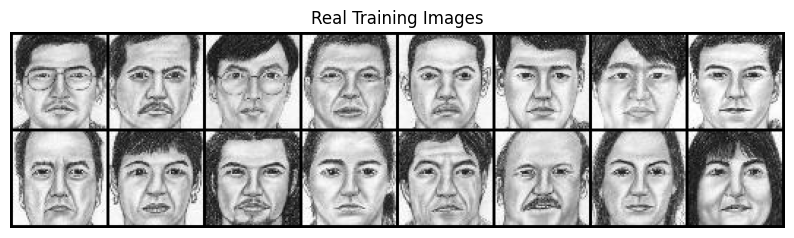


Training DCGAN...
[0/100][0/19] Loss_D: 1.5271 Loss_G: 2.0104
[1/100][0/19] Loss_D: 0.0238 Loss_G: 6.6181
[2/100][0/19] Loss_D: 0.0147 Loss_G: 7.0737
[3/100][0/19] Loss_D: 0.0074 Loss_G: 8.1945
[4/100][0/19] Loss_D: 1.6423 Loss_G: 15.4546
[5/100][0/19] Loss_D: 0.9484 Loss_G: 10.7461
[6/100][0/19] Loss_D: 1.9832 Loss_G: 12.1874
[7/100][0/19] Loss_D: 0.7145 Loss_G: 3.5615
[8/100][0/19] Loss_D: 1.1047 Loss_G: 3.3877
[9/100][0/19] Loss_D: 0.5766 Loss_G: 4.7124
[10/100][0/19] Loss_D: 0.6500 Loss_G: 3.4406
[11/100][0/19] Loss_D: 1.1236 Loss_G: 5.8635
[12/100][0/19] Loss_D: 1.0237 Loss_G: 5.5099
[13/100][0/19] Loss_D: 0.6598 Loss_G: 4.0259
[14/100][0/19] Loss_D: 0.8939 Loss_G: 4.3204
[15/100][0/19] Loss_D: 2.3302 Loss_G: 5.9689
[16/100][0/19] Loss_D: 0.5039 Loss_G: 3.5800
[17/100][0/19] Loss_D: 0.7122 Loss_G: 2.9848
[18/100][0/19] Loss_D: 1.1667 Loss_G: 3.9391
[19/100][0/19] Loss_D: 0.9877 Loss_G: 1.9141
[20/100][0/19] Loss_D: 0.5681 Loss_G: 5.2482
[21/100][0/19] Loss_D: 0.4733 Loss_G: 4.472

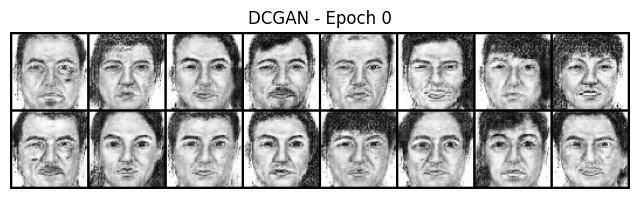

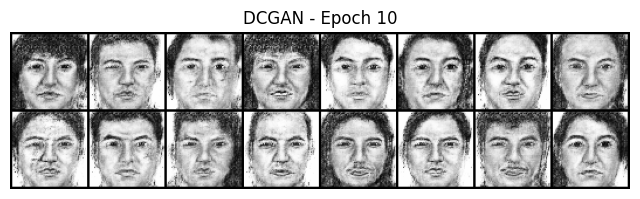

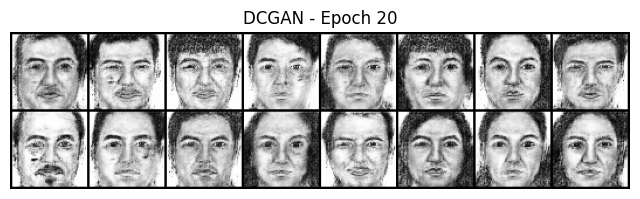

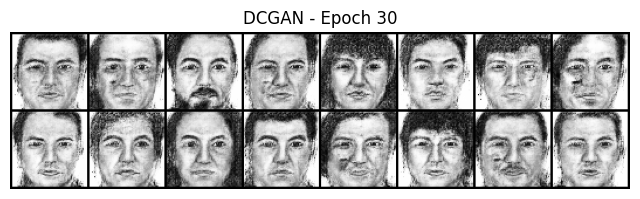

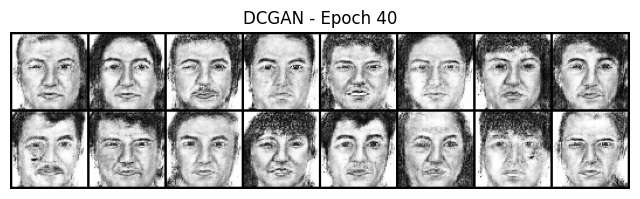

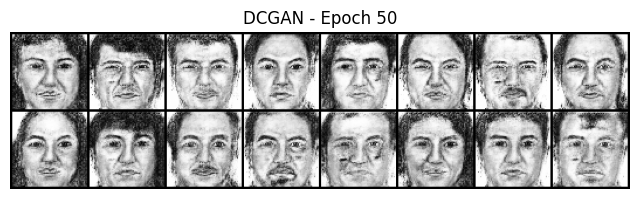

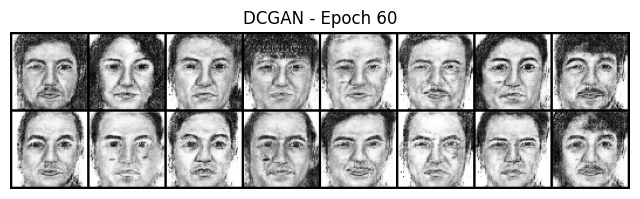

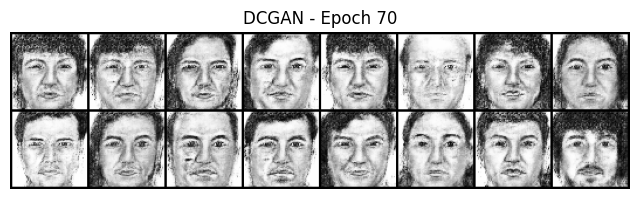

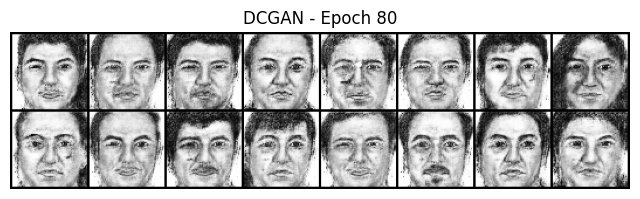

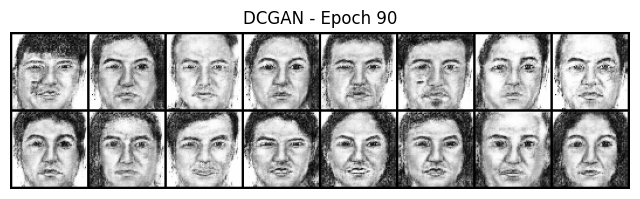


Training WesternGAN...
[0/100][0/19] Loss_D: 1.5274 Loss_G: 1.6970
[1/100][0/19] Loss_D: 0.0981 Loss_G: 6.4677
[2/100][0/19] Loss_D: 0.0947 Loss_G: 6.9167
[3/100][0/19] Loss_D: 0.0899 Loss_G: 7.8585
[4/100][0/19] Loss_D: 0.0715 Loss_G: 7.6532
[5/100][0/19] Loss_D: 0.0859 Loss_G: 23.0362
[6/100][0/19] Loss_D: 1.1099 Loss_G: 22.4409
[7/100][0/19] Loss_D: 0.1019 Loss_G: 16.3187
[8/100][0/19] Loss_D: 0.0862 Loss_G: 8.8311
[9/100][0/19] Loss_D: 1.9056 Loss_G: 14.7830
[10/100][0/19] Loss_D: 1.0351 Loss_G: 10.7166
[11/100][0/19] Loss_D: 0.3708 Loss_G: 3.6799
[12/100][0/19] Loss_D: 0.5507 Loss_G: 4.6523
[13/100][0/19] Loss_D: 0.9163 Loss_G: 3.4239
[14/100][0/19] Loss_D: 0.7976 Loss_G: 5.9956
[15/100][0/19] Loss_D: 0.5973 Loss_G: 2.9540
[16/100][0/19] Loss_D: 0.6839 Loss_G: 3.0805
[17/100][0/19] Loss_D: 0.3477 Loss_G: 6.1937
[18/100][0/19] Loss_D: 0.7716 Loss_G: 5.5139
[19/100][0/19] Loss_D: 0.4981 Loss_G: 4.6162
[20/100][0/19] Loss_D: 0.2147 Loss_G: 5.1569
[21/100][0/19] Loss_D: 0.7215 Loss_G

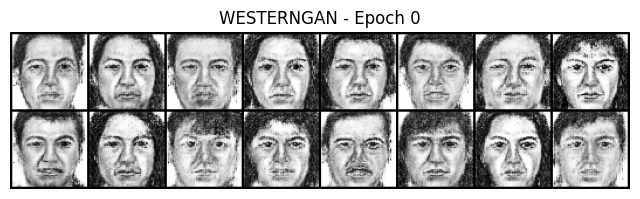

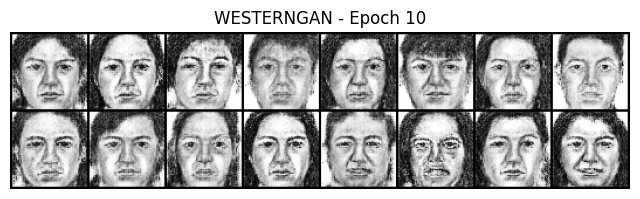

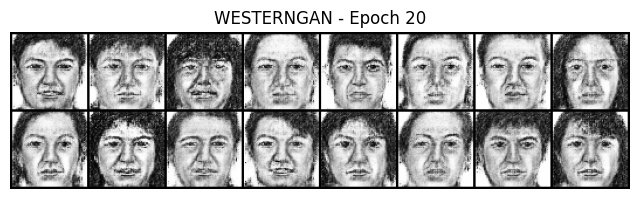

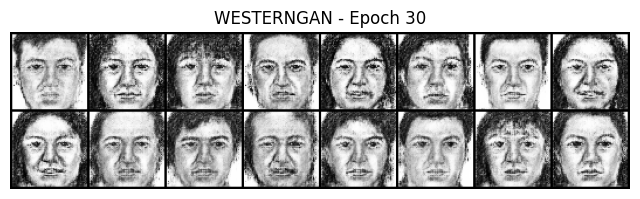

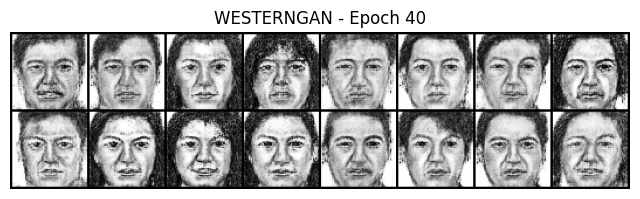

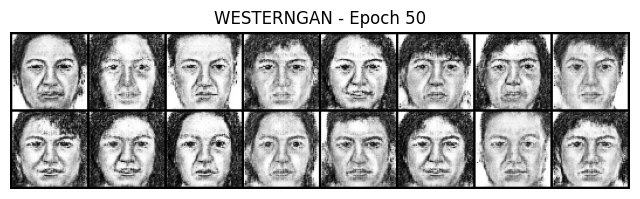

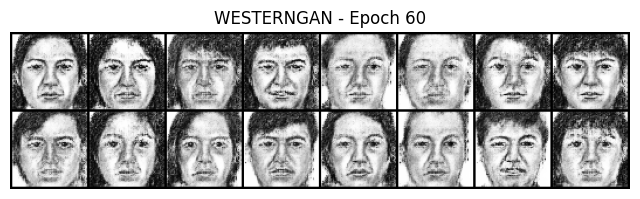

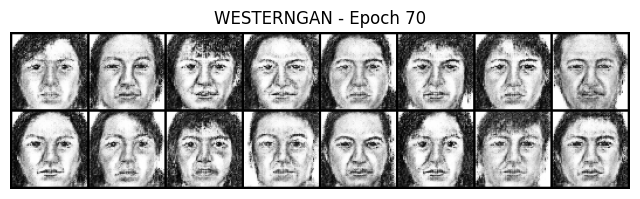

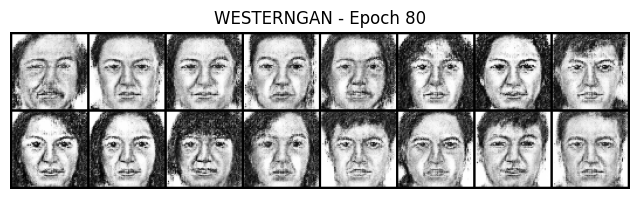

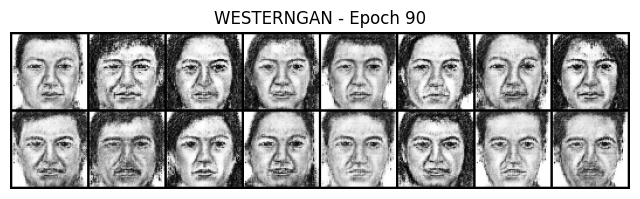


Training VAE...
[0/100][0/19] Recon Loss: 0.3654 KL Loss: 0.0000 Total Loss: 0.3655
[1/100][0/19] Recon Loss: 0.2646 KL Loss: 0.0037 Total Loss: 0.2683
[2/100][0/19] Recon Loss: 0.2142 KL Loss: 0.0048 Total Loss: 0.2190
[3/100][0/19] Recon Loss: 0.1956 KL Loss: 0.0052 Total Loss: 0.2008
[4/100][0/19] Recon Loss: 0.1651 KL Loss: 0.0078 Total Loss: 0.1728
[5/100][0/19] Recon Loss: 0.1536 KL Loss: 0.0063 Total Loss: 0.1599
[6/100][0/19] Recon Loss: 0.1434 KL Loss: 0.0059 Total Loss: 0.1493
[7/100][0/19] Recon Loss: 0.1351 KL Loss: 0.0059 Total Loss: 0.1410
[8/100][0/19] Recon Loss: 0.1148 KL Loss: 0.0067 Total Loss: 0.1215
[9/100][0/19] Recon Loss: 0.1079 KL Loss: 0.0083 Total Loss: 0.1162
[10/100][0/19] Recon Loss: 0.1006 KL Loss: 0.0082 Total Loss: 0.1089
[11/100][0/19] Recon Loss: 0.0982 KL Loss: 0.0086 Total Loss: 0.1068
[12/100][0/19] Recon Loss: 0.0886 KL Loss: 0.0087 Total Loss: 0.0972
[13/100][0/19] Recon Loss: 0.0874 KL Loss: 0.0089 Total Loss: 0.0963
[14/100][0/19] Recon Loss: 

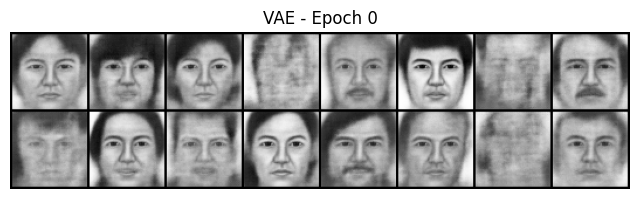

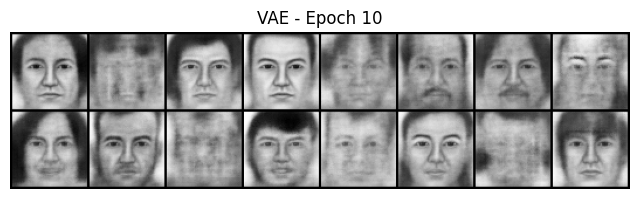

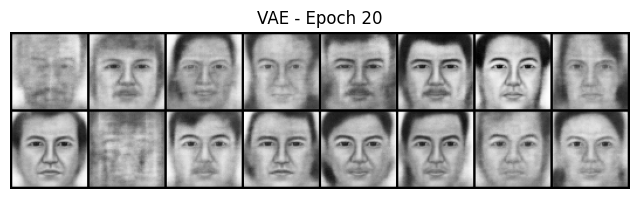

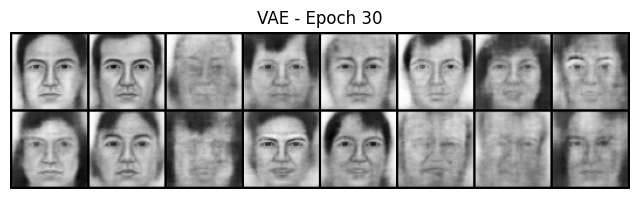

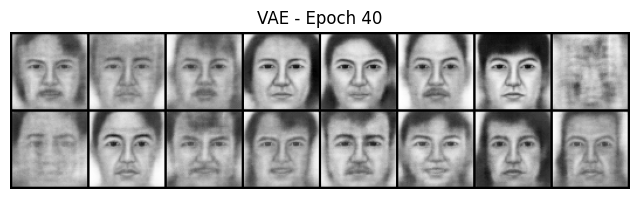

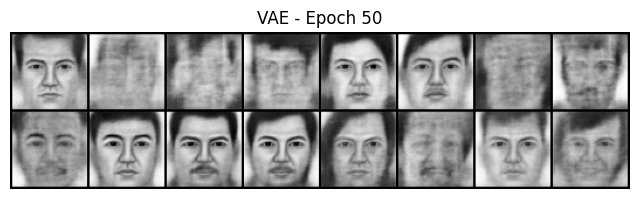

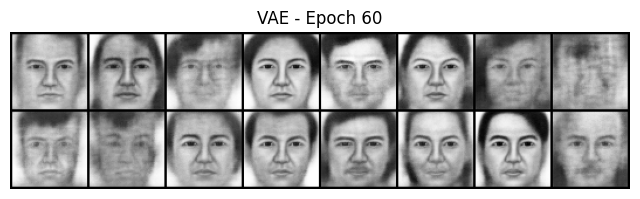

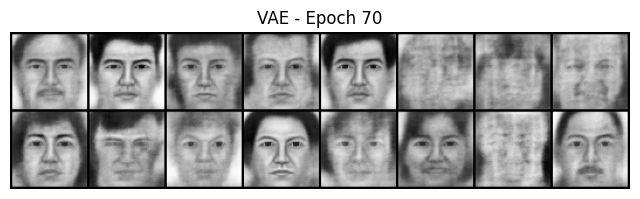

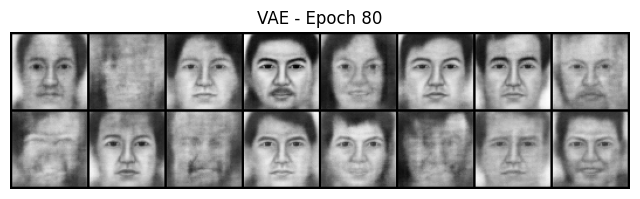

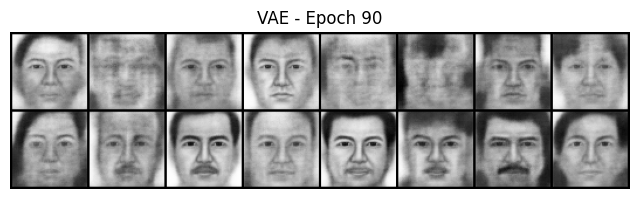


Final Generated Samples from All Models:


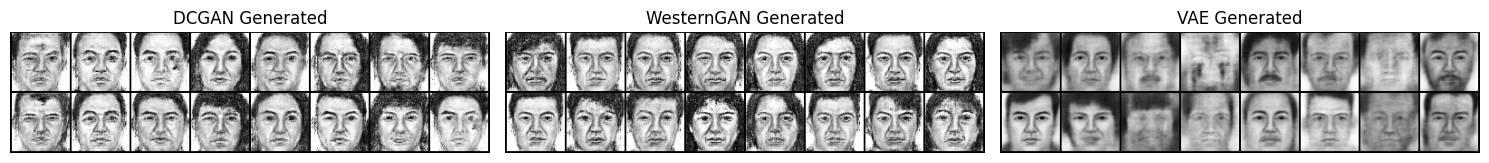

Training complete. Models saved.

Generated Images from Saved Models:


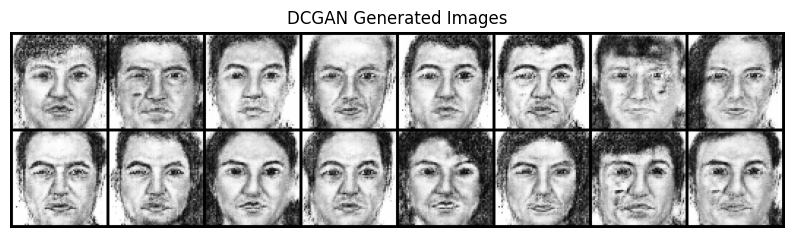

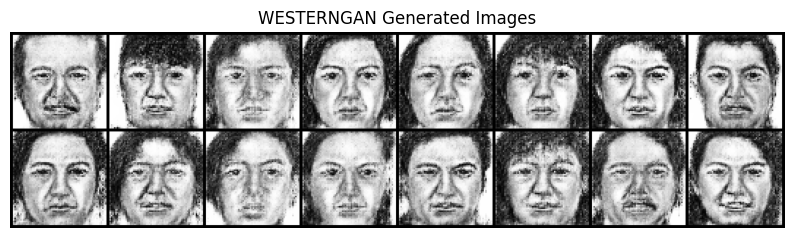

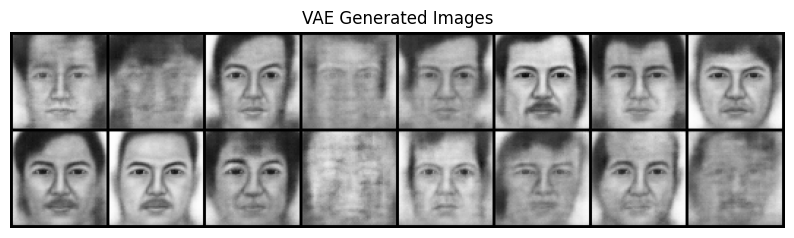

In [24]:
# Cell: Visualization Functions for Model Outputs
def display_generated_images(model_type, model, num_samples=16):
    plt.figure(figsize=(10, 10))
    with torch.no_grad():
        if model_type in ['dcgan', 'westerngan']:
            # For GANs
            noise = torch.randn(num_samples, LATENT_DIM, 1, 1).to(device)
            fake_images = model(noise).cpu()
        else:
            # For VAE
            noise = torch.randn(num_samples, LATENT_DIM).to(device)
            fake_images = model.decode(noise).cpu()
        
        # Create a grid of generated images
        img_grid = vutils.make_grid(fake_images, padding=2, normalize=True)
        plt.imshow(np.transpose(img_grid, (1, 2, 0)), cmap='gray')
        plt.axis('off')
        plt.title(f'{model_type.upper()} Generated Images')
        plt.show()

def display_training_progress(model_type, model, epoch, num_samples=16):
    plt.figure(figsize=(8, 8))
    with torch.no_grad():
        if model_type in ['dcgan', 'westerngan']:
            noise = torch.randn(num_samples, LATENT_DIM, 1, 1).to(device)
            fake_images = model(noise).cpu()
        else:
            noise = torch.randn(num_samples, LATENT_DIM).to(device)
            fake_images = model.decode(noise).cpu()
        
        img_grid = vutils.make_grid(fake_images, padding=2, normalize=True)
        plt.imshow(np.transpose(img_grid, (1, 2, 0)), cmap='gray')
        plt.axis('off')
        plt.title(f'{model_type.upper()} - Epoch {epoch}')
        plt.show()

def display_real_samples(dataloader):
    # Get a batch of real images
    real_batch = next(iter(dataloader))
    plt.figure(figsize=(10, 10))
    img_grid = vutils.make_grid(real_batch[:16], padding=2, normalize=True)
    plt.imshow(np.transpose(img_grid, (1, 2, 0)), cmap='gray')
    plt.axis('off')
    plt.title('Real Training Images')
    plt.show()

def compare_all_models(dcgan_model, westerngan_model, vae_model, num_samples=16):
    plt.figure(figsize=(15, 5))
    
    # DCGAN
    plt.subplot(1, 3, 1)
    with torch.no_grad():
        noise = torch.randn(num_samples, LATENT_DIM, 1, 1).to(device)
        dcgan_images = dcgan_model(noise).cpu()
        img_grid = vutils.make_grid(dcgan_images, padding=2, normalize=True)
        plt.imshow(np.transpose(img_grid, (1, 2, 0)), cmap='gray')
        plt.axis('off')
        plt.title('DCGAN Generated')
    
    # WesternGAN
    plt.subplot(1, 3, 2)
    with torch.no_grad():
        noise = torch.randn(num_samples, LATENT_DIM, 1, 1).to(device)
        western_images = westerngan_model(noise).cpu()
        img_grid = vutils.make_grid(western_images, padding=2, normalize=True)
        plt.imshow(np.transpose(img_grid, (1, 2, 0)), cmap='gray')
        plt.axis('off')
        plt.title('WesternGAN Generated')
    
    # VAE
    plt.subplot(1, 3, 3)
    with torch.no_grad():
        noise = torch.randn(num_samples, LATENT_DIM).to(device)
        vae_images = vae_model.decode(noise).cpu()
        img_grid = vutils.make_grid(vae_images, padding=2, normalize=True)
        plt.imshow(np.transpose(img_grid, (1, 2, 0)), cmap='gray')
        plt.axis('off')
        plt.title('VAE Generated')
    
    plt.tight_layout()
    plt.show()

# Cell: Modified Training Loop with Visualization
def train_with_visualization(dataloader, num_epochs, display_frequency=10):
    # Display some real samples first
    print("Real Training Samples:")
    display_real_samples(dataloader)
    
    # Train DCGAN
    print("\nTraining DCGAN...")
    dcgan_G, dcgan_D, dcgan_G_losses, dcgan_D_losses = train_dcgan(dataloader, num_epochs)
    for epoch in range(0, num_epochs, display_frequency):
        display_training_progress('dcgan', dcgan_G, epoch)
    
    # Train WesternGAN
    print("\nTraining WesternGAN...")
    western_G, western_D, western_G_losses, western_D_losses = train_westerngan(dataloader, num_epochs)
    for epoch in range(0, num_epochs, display_frequency):
        display_training_progress('westerngan', western_G, epoch)
    
    # Train VAE
    print("\nTraining VAE...")
    vae_model, recon_losses, kl_losses, total_losses = train_vae(dataloader, num_epochs)
    for epoch in range(0, num_epochs, display_frequency):
        display_training_progress('vae', vae_model, epoch)
    
    # Display final results
    print("\nFinal Generated Samples from All Models:")
    compare_all_models(dcgan_G, western_G, vae_model)
    
    return dcgan_G, western_G, vae_model

# Cell: Execute Training with Visualization
if __name__ == "__main__":
    # Start training with visualizations
    dcgan_model, western_model, vae_model = train_with_visualization(
        dataloader, 
        NUM_EPOCHS, 
        display_frequency=10  # Show progress every 10 epochs
    )
    
    # Save the models
    torch.save(dcgan_model.state_dict(), 'dcgan_generator.pth')
    torch.save(western_model.state_dict(), 'westerngan_generator.pth')
    torch.save(vae_model.state_dict(), 'vae_model.pth')
    
    print("Training complete. Models saved.")
    
    # Display final results again
    print("\nGenerated Images from Saved Models:")
    display_generated_images('dcgan', dcgan_model)
    display_generated_images('westerngan', western_model)
    display_generated_images('vae', vae_model)